### Interactive Testing of the Python EKF

In [1]:
'''
Reconstructing 3D points from 2D camera views
'''

import numpy as np
import sys
sys.path.insert(1, '../synth_data')
import data_gen as dg
from ekf import EKF

In [2]:
data = np.load('../synth_data/synth_data.npz')
data

NpzFile '../synth_data/synth_data.npz' with keys: ground_truth_clouds, camera_projections, camera_positions, camera_matrices

In [3]:
camera_matrices = data['camera_matrices']
camera_projections = data['camera_projections']

In [4]:
camera_projections = camera_projections.swapaxes(1, 2) # swap point index and camera index
camera_projections.shape

(100, 10, 10, 2)

Single Timestep Test

In [5]:
pt_obs = camera_projections[0, 5]
pt_obs.shape

(10, 2)

In [6]:
filt = EKF(1e-3 * np.eye(2), 1e-6 * np.eye(3), np.zeros(3), 1e3 * np.eye(3))
filt.multifilter(pt_obs, camera_matrices, timesteps=[0] * pt_obs.shape[0])
filt.x, filt.cov

(array([-4.80677799,  1.4855013 , -3.2330185 ]),
 array([[ 1.26471411e-04,  9.45127455e-06, -1.57813858e-05],
        [ 9.45126790e-06,  1.85814690e-04,  2.85273434e-05],
        [-1.57813845e-05,  2.85273676e-05,  1.63547084e-04]]))

In [7]:
gt = data['ground_truth_clouds']
correct = gt[0, 5] # first time step, 6th point
correct

array([-4.80677853,  1.48550144, -3.23301891])

In [8]:
filt.x - correct

array([ 5.42858663e-07, -1.38368398e-07,  4.10515749e-07])

Multi Timestep Test and Error Tracking

In [9]:
errors = []
recons = []

filt = EKF(1e-3 * np.eye(2), 1e-6 * np.eye(3), np.zeros(3), 1e3 * np.eye(3))
for i in range(camera_projections.shape[0]):
    observations = camera_projections[i, 0]
    filt.multifilter(observations, camera_matrices, timesteps=[i] * observations.shape[0])
    errors.append(np.linalg.norm(filt.x - gt[0, 0]))
    recons.append(filt.x)

    # reset filter
    filt.x = np.zeros(3)
    filt.cov = 1e3 * np.eye(3)

Text(0, 0.5, 'Reconstruction L2-norm Error')

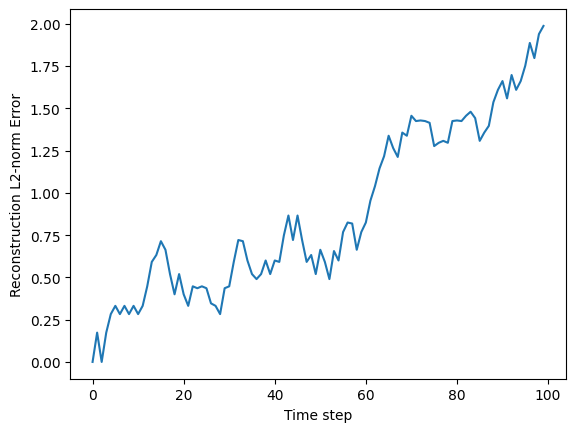

In [10]:
import matplotlib.pyplot as plt
plt.plot(errors)
plt.xlabel('Time step')
plt.ylabel('Reconstruction L2-norm Error')

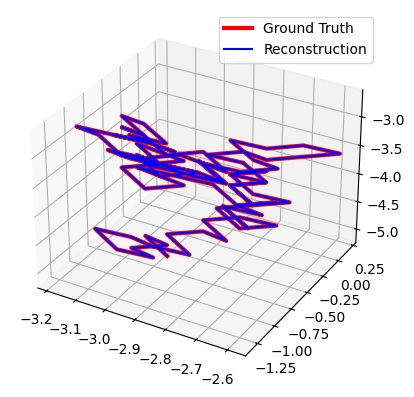

In [11]:
point0_gt = gt[:, 0]

# plot ground truth path of point 0
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(point0_gt[:100, 0], point0_gt[:100, 1], point0_gt[:100, 2], c='r', linewidth=3, label='Ground Truth')

recons = np.array(recons)
ax.plot(recons[:, 0], recons[:, 1], recons[:, 2], c='b', label='Reconstruction')
ax.legend()

Concurrency Test (WIP)

In [19]:
import concurrent.futures

def reconstruct_point_path(pt_idx):
    filt = EKF(1e-3 * np.eye(2), 1e-6 * np.eye(3), np.zeros(3), 1e3 * np.eye(3))

    recons = []
    for i in range(camera_projections.shape[0]):
        observations = camera_projections[i, pt_idx]
        filt.multifilter(observations, camera_matrices, timesteps=[i] * observations.shape[0])
        recons.append(filt.x)

        # reset filter
        filt.x = np.zeros(3)
        filt.cov = 1e3 * np.eye(3)
    
    return recons


with concurrent.futures.ThreadPoolExecutor() as executor:
    futures = [executor.submit(reconstruct_point_path, i) for i in range(camera_projections.shape[1])]
    recons = [f.result() for f in futures]

recons = np.array(recons)
recons = recons.swapaxes(0, 1)
recons.shape

(100, 10, 3)

/var/folders/q_/vyck0rnj52s7g0k52c4p5jr40000gn/T/ipykernel_73692/4003161478.py:8: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(cloud[:, 0], cloud[:, 1], cloud[:, 2], c=[i/N, 0, 1 - i/N])


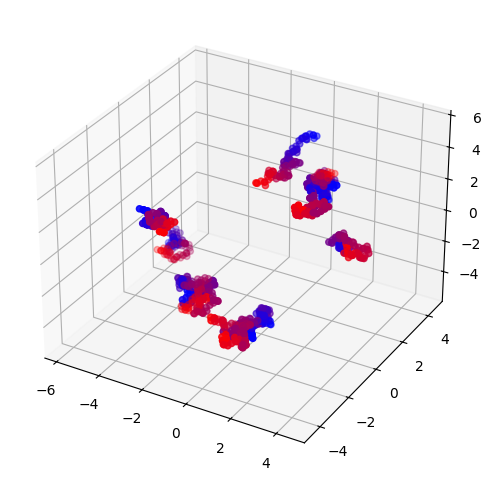

In [20]:
gt = data['ground_truth_clouds'][:100]
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(projection='3d')
#smooth color transition from light to dark
N = gt.shape[0]
for i in range(N):
    cloud = gt[i]
    ax.scatter(cloud[:, 0], cloud[:, 1], cloud[:, 2], c=[i/N, 0, 1 - i/N])

Text(0.5, 0.92, 'Reconstructed 3D point cloud, latest point in blue')

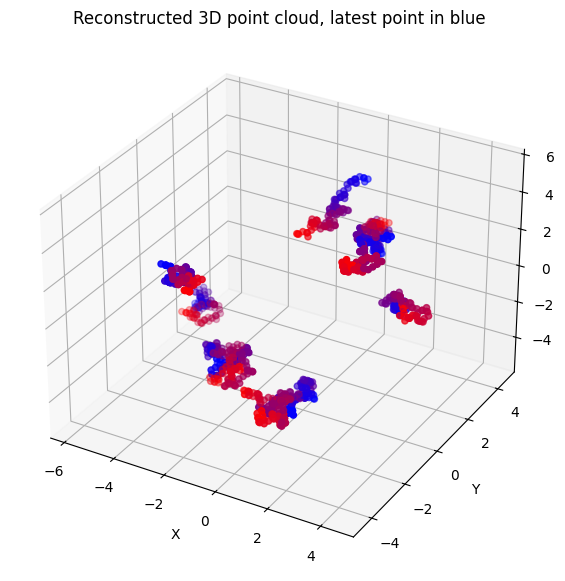

In [21]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(projection='3d')
N = gt.shape[0]
for i in range(N):
    cloud = recons[i]
    ax.scatter(cloud[:, 0], cloud[:, 1], cloud[:, 2], color=[i/N, 0, 1 - i/N])

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Reconstructed 3D point cloud, latest point in blue')

In [22]:
error = np.linalg.norm(recons - gt, axis=2)
np.mean(error)

7.557762235506827e-07

Concurrency performance test

In [16]:
import time

with concurrent.futures.ThreadPoolExecutor() as executor:
    start = time.time()
    futures = [executor.submit(reconstruct_point_path, i) for i in range(camera_projections.shape[1])]
    recons = [f.result() for f in futures]
    end = time.time()
    print(end - start)

0.11271882057189941


In [17]:
recons = []
start = time.time()
for i in range(camera_projections.shape[1]):
    recons.append(reconstruct_point_path(i))
end = time.time()
print(end - start)

0.11053085327148438


Negligible performance difference. ThreadPools aren't actuall parallelized here, we need ProcessPools which don't behave in Jupyter. This will be futher tested in the multi-filter approach that will be set up to field packet streams.

In [18]:
gt[-1]

array([[-2.98677916, -0.61373305, -5.19661538],
       [-1.80610637, -4.00043661,  3.10311351],
       [-1.08186316, -1.82765471, -3.9810013 ],
       [ 0.39641805,  4.3808958 ,  0.9485443 ],
       [ 3.14992539, -2.00725909,  4.78844645],
       [-5.30677853,  0.58550144, -3.13301891],
       [ 0.94442663, -3.82268737, -2.25838284],
       [ 3.57305327,  0.58785592,  0.7753815 ],
       [-0.67618449,  0.63024828,  2.93596293],
       [-1.29285099, -2.2652807 , -2.67988519]])